# Introduction to the ACCESS-NRI Intake catalog

**Aims**: This tutorial will introduce the ACCESS-NRI Intake catalog a show you how to use it to find and load model data for analysis

**Project membership requirements**:

 - If using the `xp65` conda environment: `xp65`, `dk92`, `fs38` and `p73`
 - If using the `hh5` conda environment: as above but also `hh5`


The ACCESS-NRI Intake Catalog is curated by ACCESS-NRI with further information on its <a href="https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html" target="_blank">documentation website</a> and <a href="https://access-hive.org.au/model_evaluation/model_evaluation_model_catalogs" target="_blank">this ACCESS-Hive page</a>.

----

# Opening the catalog 

We'll start by opening the catalog and getting a feel for what it contains.

In [1]:
import intake

catalog = intake.cat.access_nri

With that, we can now use `catalog` to search and load ~3 PB of data without having to know where the data is or how it's structured. 

The catalog includes a wide variety of climate data products. The "name" column gives the name of the data product and the other columns provide additional metadata associated with each product. As we'll demonstrate below, you can search on metadata in these columns to filter for data products that may be of interest to you. Scroll through the products below and get an idea for what each product is by looking at the entry in the description column.

In [2]:
catalog

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{1day, fx, 3hr, 1mon, 3mon}","{uvel_m, total_ocean_runoff, sens_heat, total_ocean_calving_melt_heat, sss_m, tx_trans_rho, total_ocean_evap_heat, total_ocean_river, river, frazil_m, temp_submeso, flatn_ai_m, evap, total_ocean_l..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{congel, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, total_ocean_calving_melt_heat, uvel_m, total_ocean_evap_heat, total_ocean_river, river, frazil_m, flatn_ai_m, evap, tot..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{Sinz, congel, fcondtop_ai, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, total_ocean_evap_heat, surface_pot_temp_max, total_ocean_river, river, frazil_m, flat..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{Sinz, congel, fcondtop_ai, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, tx_trans_rho, total_ocean_evap_heat, surface_pot_temp_max, total_ocean_river, river, ..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 3hr, 6hr, 1mon}","{Sinz, total_ocean_mh_flux, stf03, uvel_m, surface_phy, surface_pot_temp_max, flatn_ai_m, usurf, TLAT, skl_Nit_m, det_xflux_adv, divu_h, dyu, average_T2, sea_level_sq, no3_int100, vert_pv, dardg2d..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon, 0hr}","{congel, fcondtop_ai, total_ocean_mh_flux, stf03, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, surface_phy, tx_trans_rho, total_ocean_evap_heat, surface_pot_temp_max, stf07, total..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1/1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do \nv1.5.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{temp_int_rhodz, sens_heat, river, evap, aice_m, TLAT, ekman_we, hu, dyu, lprec, dyt, fprec_melt_heat, diff_cbt_t, average_T2, sea_level_sq, evap_heat, ty_trans_rho, eta_nonbouss, temp, sfc_hflux_..."
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{ocean, seaIce}","{1day, fx, 1yr, 1mon}","{patm_t, congel, fcondtop_ai, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, tx_trans_rho, total_ocean_evap_heat, surface_pot_temp_max, total_ocean_river, frazi..."
025deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{ocean, seaIce}","{1day, fx, 1yr, 1mon}","{patm_t, congel, fcondtop_ai, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, tx_trans_rho, total_ocean_evap_heat, surface_pot_temp_max, total_ocean_river, frazi..."


# Using the catalog

Each entry (row) in the catalog describes a data product comprising many datasets spread across many files (a "dataset" here is a set of files that can be readily opened and combined for analysis using xarray - more on this later). For example, in a given ACCESS-CM2 product, there may be a dataset of ocean variables at monthly frequency, atmospheric variables at monthly frequency etc. Each entry in the catalog has a corresponding Intake-ESM datastore that can be used to filter for datasets of interest based on metadata in the datastore and then to open those datasets using xarray.

The general process for using the catalog is as follows:

1. Search the ACCESS-NRI catalog for data products that are of interest to you.
2. Open the Intake-ESM datastore(s) for the product(s) of interest. 
3. Search the Intake-ESM datastore(s) for the datasets within each product that are of interest to you.
4. Open the datasets of interest as xarray Dataset(s).
5. Perform some analysis on the xarray Dataset(s).

This process is illustrated in the schematic below. Pink text indicates the methods used to perform each task.

<img src="../assets/catalog_flow.svg" alt="Alternative text" />

If a user knows in advance the name of the product(s) they are after, then the first two steps above are not needed. Instead, those Intake-ESM datastores can be easily retreived directly from the catalog as demonstrated later on.

# Catalog filtering and data discovery

We can search on the columns in the ACCESS-NRI catalog. For example, we could search for all products that use the model `ACCESS-OM2`. The `search` method returns another catalog object with entries that satisfy our search criteria.

In [3]:
catalog_filtered_example = catalog.search(model="ACCESS-OM2")
catalog_filtered_example

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{1day, fx, 3hr, 1mon, 3mon}","{uvel_m, total_ocean_runoff, sens_heat, total_ocean_calving_melt_heat, sss_m, tx_trans_rho, total_ocean_evap_heat, total_ocean_river, river, frazil_m, temp_submeso, flatn_ai_m, evap, total_ocean_l..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{congel, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, total_ocean_calving_melt_heat, uvel_m, total_ocean_evap_heat, total_ocean_river, river, frazil_m, flatn_ai_m, evap, tot..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{Sinz, congel, fcondtop_ai, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, total_ocean_evap_heat, surface_pot_temp_max, total_ocean_river, river, frazil_m, flat..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{Sinz, congel, fcondtop_ai, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, tx_trans_rho, total_ocean_evap_heat, surface_pot_temp_max, total_ocean_river, river, ..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 3hr, 6hr, 1mon}","{Sinz, total_ocean_mh_flux, stf03, uvel_m, surface_phy, surface_pot_temp_max, flatn_ai_m, usurf, TLAT, skl_Nit_m, det_xflux_adv, divu_h, dyu, average_T2, sea_level_sq, no3_int100, vert_pv, dardg2d..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon, 0hr}","{congel, fcondtop_ai, total_ocean_mh_flux, stf03, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, surface_phy, tx_trans_rho, total_ocean_evap_heat, surface_pot_temp_max, stf07, total..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1/1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do \nv1.5.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{temp_int_rhodz, sens_heat, river, evap, aice_m, TLAT, ekman_we, hu, dyu, lprec, dyt, fprec_melt_heat, diff_cbt_t, average_T2, sea_level_sq, evap_heat, ty_trans_rho, eta_nonbouss, temp, sfc_hflux_..."
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{ocean, seaIce}","{1day, fx, 1yr, 1mon}","{patm_t, congel, fcondtop_ai, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, tx_trans_rho, total_ocean_evap_heat, surface_pot_temp_max, total_ocean_river, frazi..."
025deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{ocean, seaIce}","{1day, fx, 1yr, 1mon}","{patm_t, congel, fcondtop_ai, total_ocean_mh_flux, total_ocean_runoff, temp_int_rhodz, sens_heat, uvel_m, meltb, tx_trans_rho, total_ocean_evap_heat, surface_pot_temp_max, total_ocean_river, frazi..."


We can also combine queries in a search. For example, below we search for all products that use the model `ACCESS-OM2` and contain the variable `wdet100` at daily frequency.

In [4]:
catalog.search(model="ACCESS-OM2", frequency="1day", variable="wdet100")

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{wdet100}
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},{ocean},{1day},{wdet100}


We can also use regex strings in our searches. For example, we could relax our query on variable to look for any variables starting with the letter `"w"`.

In [5]:
catalog.search(model="ACCESS-OM2", frequency="1day", variable="w.*")

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},{ocean},{1day},{wt}
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{wt}
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{wdet100}
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},{ocean},{1day},{wdet100}


Note, metadata in the `realm` and `frequency` columns of the ACCESS-NRI catalog follow a standard vocabulary that is very similar to CMIP6 (but slightly more general):

 - `realm` may be one of:
   - `aerosol`,
   - `atmos`,
   - `atmosChem`,
   - `land`,
   - `landIce`,
   - `none`,
   - `ocean`,
   - `ocnBgchem`,
   - `seaIce`,
   - `unknown`
 - `frequency` may be one of (where `<int>` is an integer):
   - `fx`
   - `subhr`
   - `<int>hr`
   - `<int>day`
   - `<int>mon`
   - `<int>yr`
   - `<int>dec`
  
Some attempt has been made to use consistent model names in the `model` column (e.g. always use "ACCESS-OM2" for ACCESS-OM2), but model naming is not enforced. The variable names in the `variable` column are whatever they're called in the associated data product.

# Loading Intake sources

Remember that each entry in the catalog has an associated Intake-ESM datastore that keeps track of all the files in that product and how they fit together into datasets. There are three ways to open Intake-ESM datastores from the catalog, depening on your use case:

## 1. You know the name of the product you want

In this case, you can open the Intake-ESM datastore for that product directly as an attribute or key. For example

In [6]:
datastore_example = catalog.by647

# Or

datastore_example = catalog["by647"]

## 2. You've filtered the catalog for the products you want and there are multiple remaining

In this case, you can open the Intake-ESM datastores for all entries in a catalog using the `to_source_dict` method. For example

In [7]:
datastore_dict_example = catalog.search(model="ACCESS-OM2", frequency="1day", variable="wdet100").to_source_dict()

## 3. You've filtered the catalog for the products you want and there's only one remaining 

In this case, you can open the Intake-ESM datastore for the remaining product using the `to_source` method (note you could also use `to_source_dict` which would return a dictionary containing the Intake-ESM datastore, rather than the datastore itself). For example

In [8]:
datastore_example = catalog.search(name="by647").to_source()

# Additional source metadata

Each Intake-ESM datastore has its own `.metadata` attribute that contains additional information about that experiment.

In [9]:
catalog.by647.metadata

{'contact': 'Dave Bi',
 'created': None,
 'description': 'Standard CMIP6 ssp245 simulation, control experiment for by578 pacemaker experiment (1fd9e682-d393-4b17-a9cd-934c3a48a1f8)',
 'email': 'dave.bi@csiro.au',
 'experiment_uuid': '57243597-43c0-4a8f-a404-b10cecdeb3f7',
 'keywords': [None],
 'license': None,
 'long_description': 'Standard CMIP6 ssp245 simulation with 5 ensemble members. Control experiment  for by578 pacemaker experiment (1fd9e682-d393-4b17-a9cd-934c3a48a1f8). Branched from parent experiment in 2015',
 'model': ['ACCESS-CM2'],
 'name': 'by647',
 'nominal_resolution': ['atmos = n96', 'ocean = 1 degree'],
 'notes': 'null',
 'parent_experiment': '1c6e73fb-5380-43c1-8043-0526be2f1b8b',
 'reference': None,
 'related_experiments': ['1fd9e682-d393-4b17-a9cd-934c3a48a1f8'],
 'url': None,
 'version': 1,
 'catalog_dir': ''}

# An example workflow

(Note, up until this point we haven't actually opened any data from any products. However, below we access data from the `p73` project on Gadi. You will therefore need to be a member of this project to run this section.)

As a full example workflow, let's use the ACCESS-NRI catalog to carry out a simple analysis comparing anomalies of the global average ocean surface temperature from four ACCESS-CM2 data products. First we'll search directly for the products by their names and see what each of them are. 

In [10]:
catalog_filtered = catalog.search(name=["bx944", "by473", "by647", "by578"])

catalog_filtered

,model,description,realm,frequency,variable
name,,,,,
bx944,{ACCESS-CM2},"{Standard CMIP6 historical simulation, control experiment for by473 pacemaker experiment (948d8676-2c56-49db-8ea1-b80572b074c8)}","{ocean, seaIce, atmos}","{1day, 1mon}","{fld_s02i207, fld_s00i253, fld_s03i808, sidmasstranx, fld_s03i257, press, fld_s34i120, eta_u, fld_s34i103, fld_s02i208, fld_s04i204, fld_s34i105, fld_s05i215, sss_sq, TLAT, fld_s03i382, ice_calvin..."
by473,{ACCESS-CM2},"{Pacemaker variation of CMIP6 historical simulation, Topical Atlantic region replaced with fixed SSTs from observations}","{ocean, seaIce, atmos}","{1day, 1mon}","{fld_s02i207, fld_s00i253, fld_s03i808, sidmasstranx, fld_s03i257, press, fld_s34i120, eta_u, fld_s34i103, fld_s02i208, fld_s04i204, fld_s34i105, fld_s05i215, sss_sq, TLAT, fld_s03i382, ice_calvin..."
by578,{ACCESS-CM2},{Pacemaker variation of CMIP6 ssp245 simulation with Tropical Atlantic region replaced with fixed SSTs from observations},"{ocean, seaIce, atmos}","{1day, 1mon}","{fld_s02i207, fld_s00i253, fld_s03i808, sidmasstranx, fld_s03i257, press, fld_s34i120, eta_u, fld_s34i103, fld_s02i208, fld_s04i204, fld_s34i105, fld_s05i215, sss_sq, TLAT, fld_s03i382, ice_calvin..."
by647,{ACCESS-CM2},"{Standard CMIP6 ssp245 simulation, control experiment for by578 pacemaker experiment (1fd9e682-d393-4b17-a9cd-934c3a48a1f8)}","{ocean, seaIce, atmos}","{1day, 1mon}","{fld_s02i207, fld_s00i253, fld_s03i808, sidmasstranx, fld_s03i257, press, fld_s34i120, eta_u, fld_s34i103, fld_s02i208, fld_s04i204, fld_s34i105, fld_s05i215, sss_sq, TLAT, fld_s03i382, ice_calvin..."


Now we'll load the Intake-ESM datastores for those products using the `to_source_dict` method because there is more than one of them. This will take a few seconds.

In [11]:
datastore_dict = catalog_filtered.to_source_dict()

datastore_dict

{'bx944': <bx944 catalog with 7 dataset(s) from 12150 asset(s)>,
 'by578': <by578 catalog with 7 dataset(s) from 1350 asset(s)>,
 'by473': <by473 catalog with 7 dataset(s) from 12149 asset(s)>,
 'by647': <by647 catalog with 7 dataset(s) from 1350 asset(s)>}

Now we can use our Intake-ESM datastores to open the data we want. You learned about Intake-ESM datastores earlier today. We'll show the basics here and refer to the Intake-ESM documentation [here](https://intake-esm.readthedocs.io/en/stable/index.html) for more information on how to use Intake-ESM datastores.

We're going to use dask to help us open and process the data from these datastores. We can start a local distributed dask cluster as follows.

In [12]:
from distributed import Client

client = Client() #threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

Note, it is very helpful to monitor the dask dashboard when working with dask. Click on the dask icon on the far left of the screen (three orange and red squares) and enter the text output by the previous cell in the search bar. Each of the different orange panels is a different dashboard that you can use to monitor what dask is doing. If you don't know which to choose, the "Task Stream", "Progress", "CPU" and "Workers Memory" diagnostics are a good start. Click on these, and drag the windows to where ever you want them in your JupyterLab.

In these ACCESS-CM2 products, monthly global average ocean surface temperatures are available in the variable `temp_surface_ave`. We can open an xarray Dataset with `temp_surface_ave` from the Intake-ESM datastore for each product as follows. The opening of these files will be parallelized across our dask cluster - watch you dask dashboard when you execute the following cell. Note that, because the datasets here are small, we've chosen to load them immediately using `load()`.

In [13]:
dataset_dict = {
    name: datastore.search(variable="temp_surface_ave").to_dask().load()
    for name, datastore in datastore_dict.items()
}

The following function will calculate the anomalies of a provided dataset relative to the climatological mean of another dataset over the period 1971-2000. Here we'll calculate the anomalies for each product relative to the "bx944" standard historical run.

In [14]:
def anomalize(dataset, dataset_baseline, period=slice("1971","2000")):
    """
    Calculate the anomalies of ds relative to the climatological mean of ds_baseline over period
    """
    clim = dataset_baseline.sel(time=period).mean("member").groupby("time.month").mean("time")
    return dataset.groupby("time.month") - clim

In [15]:
anomalies_dict = {
    name: anomalize(dataset, dataset_dict["bx944"]) for name, dataset in dataset_dict.items()
}

To plot our data, we'll use a simple function that receives our dictionary of anomalies and plots the timeseries

In [16]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_temp_surface_ave(dataset_dict):
    for idx, (name, ds) in enumerate(dataset_dict.items()):
        data = ds["temp_surface_ave"].squeeze()
        data.plot.line(x="time", color=f"C{idx}", add_legend=False, label=name)
    
    plt.title("Global mean ocean surface temperature")
    plt.grid()
    plt.xlim([datetime(1969,1,1), datetime(2020,12,31)])
    
    # Add legend, removing duplicates due to multiple members
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

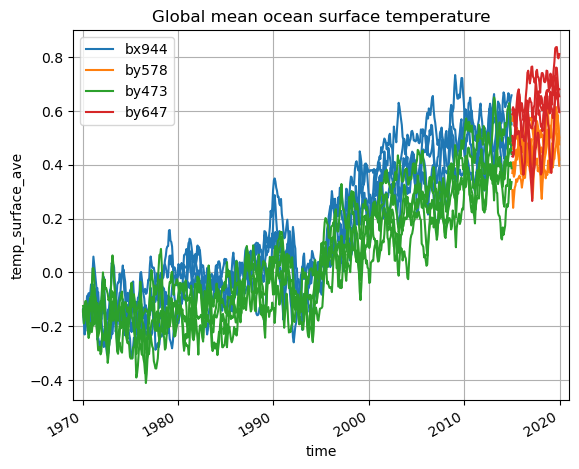

In [17]:
plot_temp_surface_ave(anomalies_dict)

Maybe we'd also like to add some CMIP6 ACCESS-CM2 data to our plot? That's easy because the [NCI CMIP Intake-ESM datastores](https://opus.nci.org.au/pages/viewpage.action?pageId=213713098) are included in the ACCESS-NRI catalog.

In [18]:
cmip6_datastore = catalog.search(name="cmip6.*", model="ACCESS-ESM1-5").to_source()

In this case however, there's no variable for global average ocean surface temperatures, so we'll have to calculate the area-weighted average ourselves from fields of ocean surface temperature.

In [19]:
tos_dataset = cmip6_datastore.search(
    source_id="ACCESS-CM2", 
    table_id="Omon", 
    variable_id="tos", 
    experiment_id="historical", 
    member_id="r1i1p1f1",
    file_type="f"
).to_dask()

area_dataset = cmip6_datastore.search(
    source_id="ACCESS-CM2", 
    table_id="Ofx", 
    variable_id="areacello", 
    experiment_id="historical", 
    member_id="r1i1p1f1",
    file_type="f"
).to_dask()

temp_surface_ave = tos_dataset["tos"].weighted(area_dataset["areacello"]).mean(["i", "j"]).to_dataset(name="temp_surface_ave").load()

Again, we'll compute the anomalies relative to the "bx944" data for consistency and add this to our dictionary of anomalies to pass on to our plotting function.

In [20]:
anomalies_dict["ACCESS-CM2 historical r1i1p1f1"] = anomalize(temp_surface_ave, dataset_dict["bx944"])

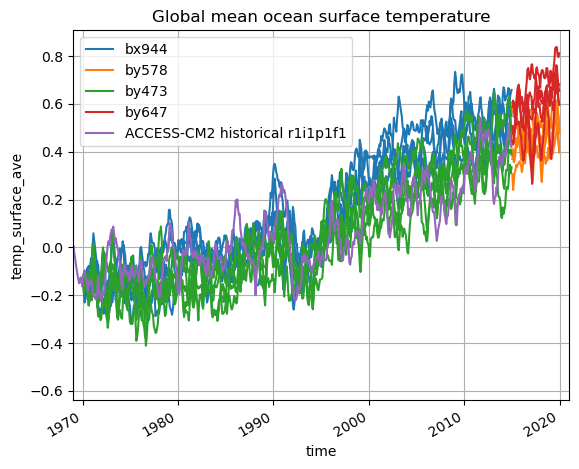

In [21]:
plot_temp_surface_ave(anomalies_dict)

## Challenge yourself

Can you add a CMIP6 ACCESS-CM2 SSP245 member to the plot?

Hint: CMIP6 experiments of the [SSP245 pathway](https://www.dkrz.de/en/communication/climate-simulations/cmip6-en/the-ssp-scenarios) have the `experiment_id = "ssp245"`

In [22]:
client.close()